In [3]:
import pandas as pd
import numpy as np
import json
import time

In [4]:
import pymongo
from pymongo import MongoClient

In [5]:
#Setup MongoDB
#Switch on my file server then run in bash: mongod --dbpath /Volumes/Data/David_Files/data/db/
client = MongoClient()
db = client.oslo_bors
collection = db.newsweb
collectionStocks = db.stocks

In [8]:
#collection.remove()
start_time = time.time()
#Scrapped range 387627:299534
for i in range(299533,290000,-1):
    url = "http://www.newsweb.no/newsweb/search.do?messageId=%d" %i
    data = pd.read_html(url)
    df = data[5]
    if pd.isnull(df.loc[1][1]):
        pass
    else:
        
        print "Article ", i, " Date: ", df.loc[1][1]
        print "Elapsed Seconds: ", time.time() - start_time
        df = df[[0,1]]
        df = df.set_index(df[0])
        df = df.drop(0,1)
        df.index.name = None
        df = df.transpose()
        df.columns = df.columns.str.replace('.','-')
        df.columns = df.columns.str.replace('$','-')
        
        #Store the data in the mongoDB
        records = json.loads(df.T.to_json(date_format='iso')).values() #Convert dataframe to json
        collection.insert(records)

Article  300000  Date:  02.03.2012 16:21
Elapsed Seconds:  0.444709062576
Article  299537  Date:  27.02.2012 17:36
Elapsed Seconds:  187.338490963
Article  299536  Date:  27.02.2012 17:35
Elapsed Seconds:  188.11916995
Article  299535  Date:  27.02.2012 17:33
Elapsed Seconds:  188.554002047
Article  299534  Date:  27.02.2012 16:56
Elapsed Seconds:  189.349781036


HTTPError: HTTP Error 500: Server Error

In [4]:
collection.count({ 'UtstederID':"EVRY" })

311

In [11]:
collection.find_one()

{u'Dato/tid': u'22.10.2015 16:26',
 u'Informasjonspliktig': u'Nei',
 u'Instrument': None,
 u'Kategori': u'SLUTTKURSER DERIVATER',
 u'Marked': u'OB',
 u'MeldingsID:\xa0387624  Generer PDF': None,
 u'Tekst': u'OBX5K\t552.31 OBX5L\t552.78 OBX6A\t553.45 OBX6C\t554.46 OBX6F\t556.12 OBX6I\t557.84',
 u'Tittel': u'OSLO B\xd8RS - CLOSING PRICES OBX FUTURES',
 u'Utsteder': u'Oslo B\xf8rs',
 u'UtstederID': u'-',
 u'Vedlegg': None,
 u'_id': ObjectId('56291b65c3b5a00221303037')}

In [6]:
scraped_tickers = collectionStocks.distinct("Ticker")

We retrive the data for each stock we have scraped data for and save it to a panda dataframe called temp_frame. This dataframe is then added to table_list, ceasting a list of all our stock panda dataframes.

In [7]:
table_list = []

for i in scraped_tickers:
    cursor = collectionStocks.find({"Ticker": i})
    temp_frame = pd.DataFrame(list(cursor))
    
    #Do some dataframe setup, turn Date back into datetime and make it the index
    temp_frame['Date'] = pd.to_datetime(temp_frame['Date'])
    #temp_frame = temp_frame.set_index(['Date'])
    #temp_frame = temp_frame.sort_index()
    
    #Create an extran column called "Daily Return"
    temp_frame['Daily return'] = temp_frame['Last'].pct_change()
    
    table_list.append(temp_frame)


Next we take our list of  panda dataframes and concat them.

In [8]:
stock_table = pd.concat(table_list)
stock_table = stock_table[['Ticker','Daily return','Date']]
stock_table = stock_table.sort(['Date'])

In [9]:
time_shift = [1,5,10,20,30]

for time in time_shift:
    shift_list = []
    gouped_stock = stock_table.groupby(['Ticker'])
    
    for name, group in gouped_stock:
        temp_frame = group.copy()
        temp_frame = temp_frame.sort(['Date'])
        temp_frame.Date = temp_frame.Date.shift(time)
        shift_list.append(temp_frame)
    
    globals()['stock_table_%d_days' % time] = pd.concat(shift_list)

In [10]:
cursor = collection.find({'UtstederID':{
            "$in": scraped_tickers #Get values where UtstederID is in '$in' the scraped ticker list
        }
        }, { 'UtstederID': 1,'Dato/tid':1, 'Tekst':1})
#len(list(cursor))
text_table = pd.DataFrame(list(cursor))

In [11]:
#Turn the data/tid into a datetime and then normalize, eg. remove the time leaving just the date
text_table['Dato/tid'] = pd.to_datetime(text_table['Dato/tid'])
text_table['Dato/tid'] = pd.DatetimeIndex(text_table['Dato/tid']).normalize()
text_table = text_table.rename(columns={'Dato/tid':'Date', 'UtstederID':'Ticker','Tekst':'Text'})

In [13]:
stock_table_1_days[stock_table_1_days['Ticker']=='AKA'].head()

,Ticker,Daily return,Date
737,AKA,-0.262803,NaT
1066,AKA,-0.208939,2010-10-07
777,AKA,-0.194387,2010-10-08
779,AKA,-0.012821,2010-10-11
1071,AKA,-0.011990,2010-10-12


In [14]:
stock_table[stock_table['Ticker']=='AKA'].head()

,Ticker,Daily return,Date
737,AKA,-0.262803,2010-10-07
1066,AKA,-0.208939,2010-10-08
777,AKA,-0.194387,2010-10-11
779,AKA,-0.012821,2010-10-12
1071,AKA,-0.011990,2010-10-13


In [65]:
#text_table = text_table.set_index(['Dato/tid'])

In [12]:
#0 day shift
merged_table = pd.merge(stock_table, text_table, how='left', on=['Date','Ticker'])
merged_table = merged_table.dropna(subset=['Daily return'])
merged_table = merged_table.dropna()
merged_table = merged_table.reset_index()

In [13]:
#1 day shift
merged_table_1day = pd.merge(stock_table_1_days, text_table, how='left', on=['Date','Ticker'])
merged_table_1day = merged_table_1day.dropna(subset=['Daily return'])
merged_table_1day = merged_table_1day.dropna()
merged_table_1day = merged_table_1day.reset_index()

In [181]:
merged_table.tail()

,index,Ticker,Daily return,Date,Text,_id
28918,191673,AUSS,0.468579,2015-10-07,New bond issue to be listed on Oslo Børs on th...,56292503c3b5a002213045d5
28919,191674,AUSS,0.468579,2015-10-07,Oslo Børs - obligasjonslån til notering på Osl...,56292503c3b5a002213045d6
28920,191688,OLT,0.209748,2015-10-07,Oslo Børs has received an application for ISIN...,562924f5c3b5a002213045b2
28921,191689,OLT,0.209748,2015-10-07,Oslo Børs har mottatt søknad om børsnotering a...,562924f5c3b5a002213045b3
28922,191705,OCY,0.707474,2015-10-07,Please find attached the Q2 2015 presentation ...,56292505c3b5a002213045db


In [182]:
merged_table_1day.tail()

,index,Ticker,Daily return,Date,Text,_id
28674,191659,ZAL,0.006061,2015-08-18,Zalaris will publish its second quarter result...,56292236c3b5a00221303f5c
28675,191661,ZAL,0.003030,2015-08-20,"On August 20th 2015, Peter T. Gogstad has sold...",562921abc3b5a00221303e0e
28676,191662,ZAL,0.003030,2015-08-20,Record half-year results for Zalaris Zalaris d...,562921e2c3b5a00221303e94
28677,191672,ZAL,0.014493,2015-09-03,"On the 6th and 9th of March 2015, Peter T. Gog...",5629386ac3b5a0022130671d
28678,191679,ZAL,0.008287,2015-09-14,First agreement with state-owned company for Z...,56291f7ec3b5a002213038b5


In [14]:
import re
import nltk
#nltk.download()  # Download text data sets, including stop words
from nltk.corpus import stopwords # Import the stop word list
print stopwords.words("english") 

[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'which', u'who', u'whom', u'this', u'that', u'these', u'those', u'am', u'is', u'are', u'was', u'were', u'be', u'been', u'being', u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing', u'a', u'an', u'the', u'and', u'but', u'if', u'or', u'because', u'as', u'until', u'while', u'of', u'at', u'by', u'for', u'with', u'about', u'against', u'between', u'into', u'through', u'during', u'before', u'after', u'above', u'below', u'to', u'from', u'up', u'down', u'in', u'out', u'on', u'off', u'over', u'under', u'again', u'further', u'then', u'once', u'here', u'there', u'when', u'where', u'why', u'how', u'all', u'any', u'both', u'each', u'few', u'more', u'most', u'other', u'some', u'such', u'no', u'nor', u

In [15]:
merged_table_1day['No_punc'] = merged_table_1day['Text'].str.lower() #All lower case
merged_table_1day['No_punc'] = merged_table_1day['No_punc'].str.replace('[^a-zA-Z]',' ') #Remove punc
merged_table_1day['No_punc'] = merged_table_1day['No_punc'].str.split() #Tokenize

In [16]:
def stopwords(x):
    from nltk.corpus import stopwords # Import the stop word list
    stops = set(stopwords.words("english"))
    word_list = []
    for word in x:
        if not word in stops:
            word_list.append(word)
    return( " ".join( word_list)) 

In [17]:
merged_table_1day['No_punc'] = merged_table_1day['No_punc'].apply(stopwords)

In [18]:
clean_words = merged_table_1day['No_punc'].tolist()

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

In [20]:
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000)

In [21]:
train_data_features = vectorizer.fit_transform(clean_words)

In [22]:
train_data_features = train_data_features.toarray()

In [23]:
print train_data_features.shape

(28679, 5000)


In [24]:
# Take a look at the words in the vocabulary
vocab = vectorizer.get_feature_names()
print vocab

[u'aalesund', u'aarskog', u'aarsnes', u'aase', u'aasen', u'ab', u'aberdeen', u'abg', u'abgsc', u'ability', u'able', u'absent', u'acc', u'accelerated', u'accello', u'accept', u'acceptance', u'acceptances', u'accepted', u'accepts', u'access', u'accessed', u'accommodation', u'accordance', u'according', u'accordingly', u'account', u'accounted', u'accounting', u'accounts', u'accrual', u'accrued', u'accuracy', u'accurate', u'achieve', u'achieved', u'achievements', u'achieving', u'acquire', u'acquired', u'acquisition', u'acquisitions', u'acreage', u'across', u'act', u'acta', u'acted', u'acting', u'action', u'actions', u'active', u'actively', u'activities', u'activity', u'actual', u'ad', u'add', u'added', u'adding', u'addition', u'additional', u'additionally', u'address', u'addressed', u'adequacy', u'adjusted', u'adjustment', u'adjustments', u'adm', u'administration', u'administrative', u'administrerende', u'admission', u'adopted', u'adr', u'adresse', u'advance', u'advanced', u'advantage', u'a

In [26]:
def binary_return(x):
    if x > 0:
        return 1
    else:
        return 0

In [27]:
merged_table_1day["Simple return"] = merged_table_1day["Daily return"].apply(binary_return)

In [84]:
import numpy as np
from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_data_features, merged_table_1day["Simple return"], test_size=0.33, random_state=78)

In [106]:
print "Random Forest Trained"
from sklearn.ensemble import RandomForestClassifier

# Initialize a Random Forest classifier with 100 trees
forest = RandomForestClassifier(n_estimators = 10, min_samples_leaf = 175)

# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
#
# This may take a few minutes to run
forest = forest.fit( x_train, y_train)

Random Forest Trained


In [107]:
result = forest.predict(x_test)

In [108]:
from sklearn import metrics

In [109]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, result)

In [45]:
#For visulisations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [83]:
fpr_save = fpr
tpr_save = tpr

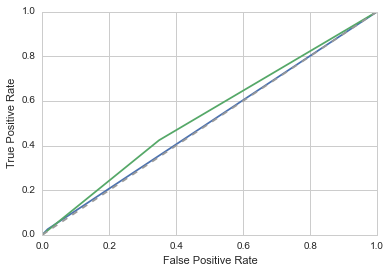

In [110]:
plt.plot(fpr,tpr)
plt.plot(fpr_save,tpr_save)
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [51]:
from sklearn import cross_validation

In [53]:
k_fold = cross_validation.KFold(len(train_data_features), 3)

In [82]:
score = 0
forest = RandomForestClassifier(n_estimators = 75, min_samples_leaf = 175)
for k, (train, test) in enumerate(k_fold):
    print k
    X_train, X_test = train_data_features[train], train_data_features[test]
    y_train, y_test = merged_table_1day["Simple return"][train], merged_table_1day["Simple return"][test]
    
    forest = forest.fit( X_train, y_train)
    
    score = score + forest.score(X_test, y_test)
    
print score/3

0
1
2
0.535827229788


10 trees = 0.513756041719
50 trees = 0.514767166491
100 trees = 0.510791833381 
10 trees + 10 min_samples_split  = 0.512047005144 
10 trees + 50 min_samples_split  = 0.512919010074
10 trees + 75 min_samples_split  = 0.505700984548 
10 trees + 10 min_samples_leaf  = 0.522717154257
10 trees + 50 min_samples_leaf  = 0.524704514413
10 trees + 100 min_samples_leaf  = 0.531643085598
10 trees + 150 min_samples_leaf  = 0.533525912548
10 trees + 200 min_samples_leaf  = 0.532061517525
10 trees + 175 min_samples_leaf = 0.535164736279
10 trees + 160 min_samples_leaf = 0.534362801936
50 trees + 175 min_samples_leaf = 0.535373915766
75 trees + 175 min_samples_leaf = 0.535827229788



In [65]:
from collections import Counter
cnt = Counter()
for number in merged_table_1day["Simple return"]:
    cnt[number] += 1

In [66]:
cnt

Counter({0: 15351, 1: 13328})

In [96]:
fpr

array([ 0.        ,  0.01094527,  1.        ])